In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import pickle

import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wandb

from jax import jit, vmap, random

from src.trainer import NetworkTrainerWandB
from src.data import load_riser_data, get_X_y, split_curve

ModuleNotFoundError: No module named 'torch'

# Data

In [5]:
df_riser = load_riser_data('data/riser.csv')
df_riser

,psup,rgl,bsw,qliq,delta_p
0,10.0,50.000000,0.010000,300.0,98.266316
1,10.0,50.000000,0.061579,300.0,98.800564
2,10.0,50.000000,0.113158,300.0,99.743402
3,10.0,50.000000,0.164737,300.0,100.252045
4,10.0,50.000000,0.216316,300.0,101.191013
...,...,...,...,...,...
142982,60.0,585.897436,0.267895,6500.0,449.306072
142983,60.0,610.256410,0.010000,6500.0,432.506369
142984,60.0,610.256410,0.061579,6500.0,438.928311
142985,60.0,610.256410,0.113158,6500.0,445.509859


In [6]:
df_train, df_test = split_curve(df_riser, 0.5)
df_train.shape, df_test.shape

((9068, 5), (133911, 5))

In [7]:
df_train.nunique()

psup          5
rgl          20
bsw          10
qliq         10
delta_p    9067
dtype: int64

# ReLU

## Medium

In [8]:
X, y= get_X_y(df_riser)
X_train, y_train = get_X_y(df_train)
X_test, y_test = get_X_y(df_test)

In [7]:
#with open('medium_nn_hp_tuning_results.pkl', 'rb') as f:
#    hp_results = pickle.load(f)

#len(hp_results)

In [9]:
# import argparse
# import time

# import sys
# sys.path.append('/data/br/oval-bab/')

# from plnn.proxlp_solver.propagation import Propagation
# from plnn.explp_solver.solver import ExpLP
# from plnn.branch_and_bound.relu_branch_and_bound import relu_bab
# from plnn.branch_and_bound.branching_scores import BranchingChoice
# import tools.bab_tools.vnnlib_utils as vnnlib_utils
# from tools.custom_torch_modules import Flatten

# import torch, copy


In [10]:
def parse_input(precision=torch.float, params=None):
    # Parse the input specifications: return network, domain, args

    torch.manual_seed(43)

    import jax

    precision = torch.float
    #params = params['__state_dict']['params']
    # Go through all layers in the model
    weights_list = []
    for key in params.keys():
        # Check if it's a dense layer
        if 'Dense' in key:
            # Save weights and biases separately
            weights = params[key]['kernel']
            bias = params[key]['bias']

            # Convert JAX array to numpy
            weights_numpy = jax.device_get(weights)
            bias_numpy = jax.device_get(bias)
            weights_list.append((weights_numpy, bias_numpy))

    # converting
    # Initialize an empty list to store the layers

    import torch.nn as nn

    # Initialize an empty list to store the layers
    layers = []

    for i, (weights, bias) in enumerate(weights_list):
        # Create a PyTorch Linear layer with the correct input and output sizes
        layer = nn.Linear(weights.shape[0], weights.shape[1])

        # Replace the layer's weights and biases with the trained weights and biases
        layer.weight = nn.Parameter(torch.from_numpy(weights.T).type(precision), requires_grad=False)
        layer.bias = nn.Parameter(torch.from_numpy(bias).type(precision), requires_grad=False)

        # Add the layer to the list of layers
        layers.append(layer)

        # Only add a ReLU activation function after a linear layer if it's not the last layer
        if i != len(weights_list) - 1:
            layers.append(nn.ReLU())

    # Create the input domain. Here, I'm just creating a dummy input domain
    input_domain = torch.tensor([[-1.5184657281879028, 1.7032906822581118], [-1.5726363509575083, 1.8872047107871084], [-1.491101810323704, 1.9295537218237684], [-1.343478719243074, 1.5389310670956662]]).type(precision)


    return layers, input_domain


NameError: name 'torch' is not defined

In [10]:
import optuna
import torch

# trocar seed

def objective(trial):
    h_layers = trial.suggest_int('h_layers', 1, 5)
    h_units = trial.suggest_int('h_units', 10, 1000)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    l2_reg = trial.suggest_float('l2_reg', 1e-5, 1e-1, log=True)
    l2_second_deriv_reg = trial.suggest_float('l2_second_deriv_reg', 1e-5, 1e-1, log=True)
    weigth_decay = trial.suggest_float('weigth_decay', 1e-5, 1e-1, log=True)
    eps_reg = trial.suggest_float('eps_reg', 1e-5, 1e-1, log=True)
    net = NetworkTrainerWandB(h_layers=h_layers, h_units=h_units, random_key=2, learning_rate=learning_rate, epochs=5000,
        l2_reg=l2_reg, weigth_decay=weigth_decay, l2_second_deriv_reg=l2_second_deriv_reg, eps_reg=eps_reg)

    net = net.fit(
        X_train, y_train,
        X_val=X_test, y_val=y_test,
        wandb_project='relu-pwl',
        # wandb_notes='Best model from first hp tuning.',
        wandb_group='TEST',
    )

    plt.plot(net.train_loss_values_, label='train')
    plt.plot(net.val_loss_values_, label='val')
    plt.yscale('log')
    plt.xlabel('epochs')
    plt.title('Mean $\ell_2$ loss on training set')
    plt.legend()
    plt.grid()
    plt.show()

    y_hat = net.predict(X_test)

    df_test['delta_p_hat'] = y_hat

    percentage_error = y_hat[:,0] - df_test['delta_p'].values

    print('Test performance')
    print('MAE =', np.abs(percentage_error).mean())
    print('max error =', np.abs(percentage_error).max())
    #net._finish_fit()

    num_neurons = h_layers * h_units

    # num neurons after fixing
    precision = torch.float

    #print(net.train_state_)
    # A network is expressed as list of torch and custom layers (custom layers defined in tools/custom_torch_modules.py)
    layers, domain = parse_input(precision=precision, params=net.train_state_.params)

    # make the input domain a batch of domains -- in this case of size 1
    batch_domain = domain.unsqueeze(0)

    gpu = True
    if gpu:
        # the copy is necessary as .cuda() acts in place for nn.Parameter
        exp_layers = [copy.deepcopy(lay).cuda() for lay in layers]
        exp_domain = batch_domain.cuda()
    else:
        exp_layers = layers
        exp_domain = batch_domain

    # Compute intermediate bounds using best bounds between CROWN and KW
    intermediate_net = Propagation(exp_layers, type="best_prop", params={"best_among": ["crown", "alpha-crown", "gamma-crown", "beta-crown"]}, max_batch=100000)

    # intermediate_net = Propagation(exp_layers, type="naive", max_batch=2000)  # uses IBP bounds -- much looser
    with torch.no_grad():
        intermediate_net.define_linear_approximation(exp_domain)
    intermediate_ubs = intermediate_net.upper_bounds
    intermediate_lbs = intermediate_net.lower_bounds

    #print(intermediate_ubs)
    #print(intermediate_lbs)
    for k in range(h_layers):
        for j in range(h_units):
            if intermediate_ubs[k+1][0][j] < 0 or intermediate_lbs[k+1][0][j] > 0:
                num_neurons -= 1
    
    print('Num neurons initial = ', h_layers * h_units)
    print('Num neurons final = ', num_neurons)
    custo = np.abs(percentage_error).mean() + num_neurons * 0.0001
    net._log_end(np.abs(percentage_error).mean(), np.abs(percentage_error).max(), num_neurons, custo)

    return custo

[I 2023-07-31 14:12:02,559] A new study created in memory with name: no-name-21af8e95-5376-443a-a1ed-d2ca6190a230


/home/seman/env/relu2/lib/python3.11/site-packages/jax/_src/random.py:463: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lseman. Use `wandb login --relogin` to force relogin


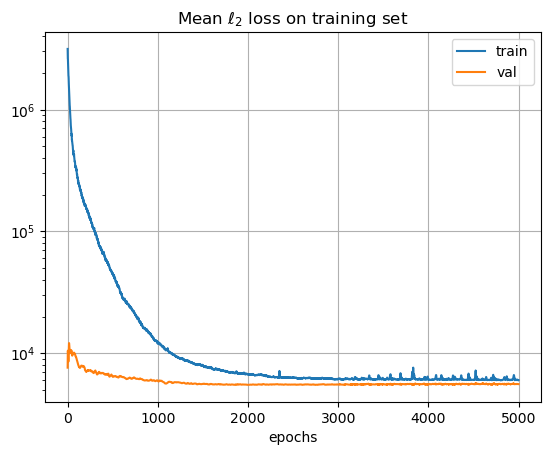

Test performance
MAE = 86.44059
max error = 305.3114
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 2: 0.156569242477417


/tmp/ipykernel_39032/1886794970.py:38: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /build/python-pytorch/src/pytorch-cuda/torch/csrc/utils/tensor_numpy.cpp:206.)
  layer.weight = nn.Parameter(torch.from_numpy(weights.T).type(precision), requires_grad=False)


<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 4: 0.014722824096679688
Num neurons initial =  1048
Num neurons final =  1048


cost,▁
mae,▁
max_error,▁
neurons,▁
train_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cost,86.54539
mae,86.44059
max_error,305.3114
neurons,1048
train_loss,6032.67236


[I 2023-07-31 14:12:37,877] Trial 0 finished with value: 86.54538990478515 and parameters: {'h_layers': 2, 'h_units': 524, 'learning_rate': 0.00016472205075591324, 'l2_reg': 5.797332267487206e-05, 'l2_second_deriv_reg': 0.041609715879485795, 'weigth_decay': 0.00037466836842646906, 'eps_reg': 0.00031665416095215865}. Best is trial 0 with value: 86.54538990478515.
/home/seman/env/relu2/lib/python3.11/site-packages/jax/_src/random.py:463: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


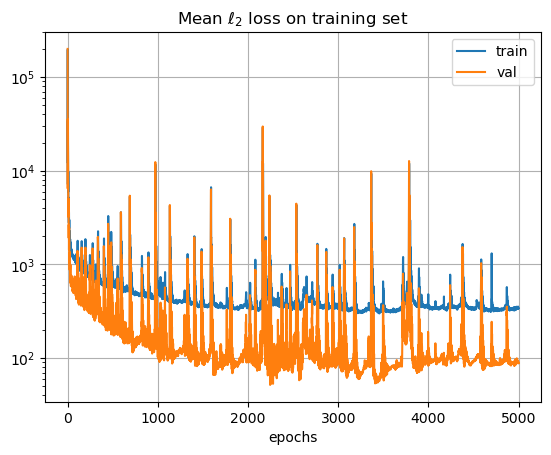

Test performance
MAE = 9.769351
max error = 78.65997
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 2: 0.012276172637939453
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 4: 0.010478019714355469
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 6: 0.013429403305053711
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 8: 0.01692366600036621
Num neurons initial =  1848
Num neurons final =  1846


cost,▁
mae,▁
max_error,▁
neurons,▁
train_loss,▇▆▄▃▃▃▂█▂▂▂▅▁▁▂▁▁▇▂▂▂▂▁▂▆▂▁▁▁▂▂▁▁▂▂▁▁▁▁▁
val_loss,▄▄▂▂▂▂▂█▁▃▁▂▁▁▁▁▁▄▁▂▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
cost,9.95395
mae,9.76935
max_error,78.65997
neurons,1846
train_loss,340.53955


[I 2023-07-31 14:13:36,073] Trial 1 finished with value: 9.953951005554199 and parameters: {'h_layers': 4, 'h_units': 462, 'learning_rate': 0.0020295146568555266, 'l2_reg': 6.26664319350798e-05, 'l2_second_deriv_reg': 0.0021200212099208825, 'weigth_decay': 9.220562677247924e-05, 'eps_reg': 0.003158607715877048}. Best is trial 1 with value: 9.953951005554199.
/home/seman/env/relu2/lib/python3.11/site-packages/jax/_src/random.py:463: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


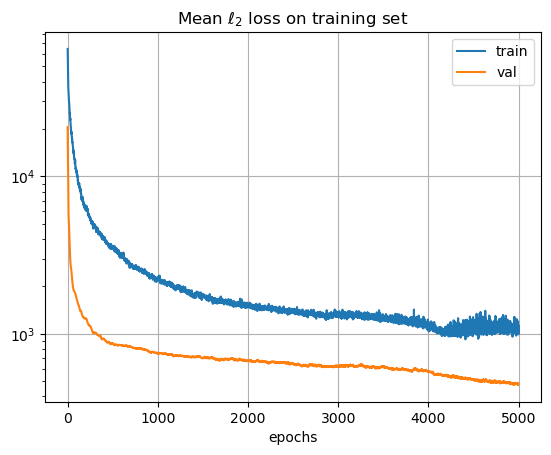

Test performance
MAE = 23.157343
max error = 141.15842
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 2: 0.011965036392211914
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 4: 0.010090112686157227
Num neurons initial =  1120
Num neurons final =  1117


cost,▁
mae,▁
max_error,▁
neurons,▁
train_loss,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
cost,23.26904
mae,23.15734
max_error,141.15842
neurons,1117
train_loss,1108.29297


[I 2023-07-31 14:14:11,197] Trial 2 finished with value: 23.2690429107666 and parameters: {'h_layers': 2, 'h_units': 560, 'learning_rate': 8.073611381957644e-05, 'l2_reg': 0.001149739807427337, 'l2_second_deriv_reg': 2.6496209540058605e-05, 'weigth_decay': 0.0357674732092971, 'eps_reg': 2.6639431395461732e-05}. Best is trial 1 with value: 9.953951005554199.
/home/seman/env/relu2/lib/python3.11/site-packages/jax/_src/random.py:463: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


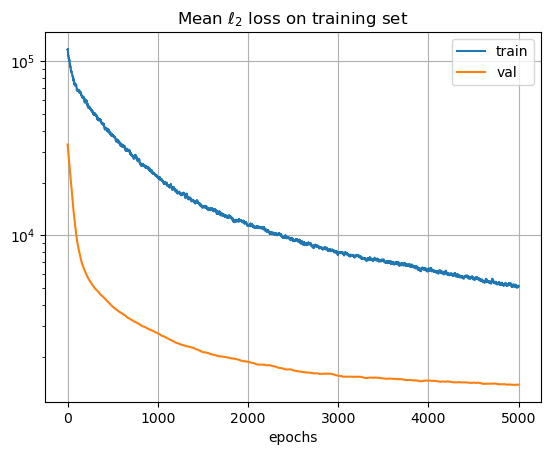

Test performance
MAE = 41.44439
max error = 207.71204
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 2: 0.012629270553588867
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 4: 0.010694265365600586
Num neurons initial =  576
Num neurons final =  576


cost,▁
mae,▁
max_error,▁
neurons,▁
train_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cost,41.50199
mae,41.44439
max_error,207.71204
neurons,576
train_loss,5114.13672


[I 2023-07-31 14:14:31,415] Trial 3 finished with value: 41.50198934326172 and parameters: {'h_layers': 2, 'h_units': 288, 'learning_rate': 1.2736238675264776e-05, 'l2_reg': 0.006941863947053046, 'l2_second_deriv_reg': 0.0015799436686758776, 'weigth_decay': 0.003706999258613576, 'eps_reg': 0.000511171952029645}. Best is trial 1 with value: 9.953951005554199.
/home/seman/env/relu2/lib/python3.11/site-packages/jax/_src/random.py:463: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


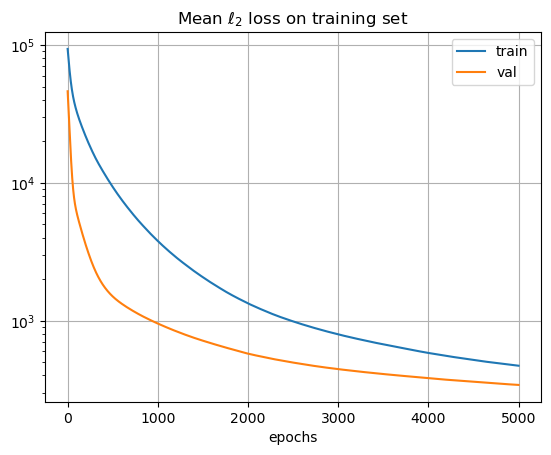

Test performance
MAE = 20.528517
max error = 118.51592
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 2: 0.007513999938964844
Num neurons initial =  565
Num neurons final =  565


cost,▁
mae,▁
max_error,▁
neurons,▁
train_loss,█▆▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cost,20.58502
mae,20.52852
max_error,118.51592
neurons,565
train_loss,470.98383


[I 2023-07-31 14:14:48,539] Trial 4 finished with value: 20.58501676940918 and parameters: {'h_layers': 1, 'h_units': 565, 'learning_rate': 6.575238809567271e-05, 'l2_reg': 0.0007077900530310441, 'l2_second_deriv_reg': 0.02464712473618403, 'weigth_decay': 9.372477212631754e-05, 'eps_reg': 0.06940336263416454}. Best is trial 1 with value: 9.953951005554199.
/home/seman/env/relu2/lib/python3.11/site-packages/jax/_src/random.py:463: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


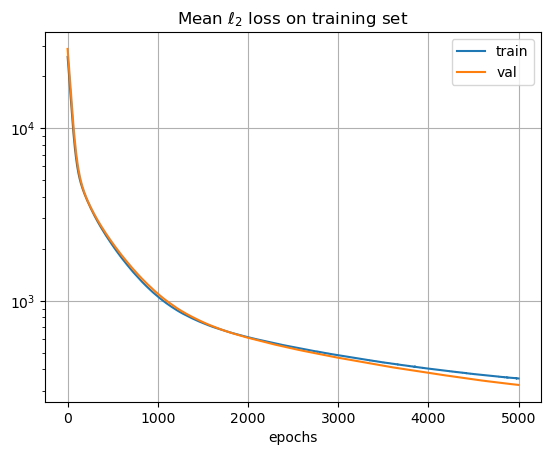

Test performance
MAE = 19.63519
max error = 110.03957
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 2: 0.007925033569335938
Num neurons initial =  327
Num neurons final =  327


cost,▁
mae,▁
max_error,▁
neurons,▁
train_loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cost,19.66789
mae,19.63519
max_error,110.03957
neurons,327
train_loss,354.18112


[I 2023-07-31 14:15:04,076] Trial 5 finished with value: 19.667889056396483 and parameters: {'h_layers': 1, 'h_units': 327, 'learning_rate': 5.6824404451464944e-05, 'l2_reg': 7.183794576843766e-05, 'l2_second_deriv_reg': 0.0010372499013164, 'weigth_decay': 0.00010381838976211366, 'eps_reg': 4.0539621538406184e-05}. Best is trial 1 with value: 9.953951005554199.
/home/seman/env/relu2/lib/python3.11/site-packages/jax/_src/random.py:463: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


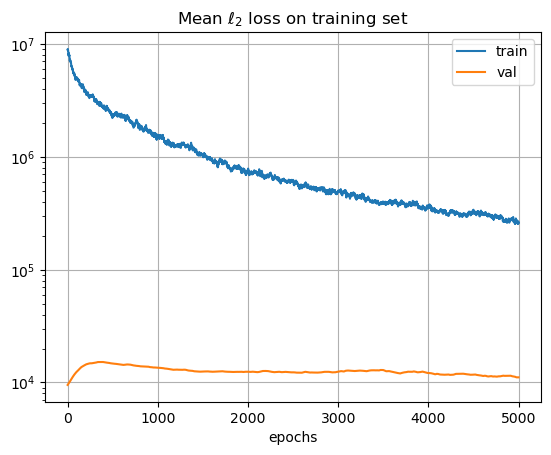

Test performance
MAE = 107.175934
max error = 416.86517
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 2: 0.012290000915527344
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 4: 0.010118246078491211
Num neurons initial =  424
Num neurons final =  424


cost,▁
mae,▁
max_error,▁
neurons,▁
train_loss,█▇▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▄▇█▇▇▆▆▅▄▄▃▃▃▃▃▃▄▃▃▃▃▃▃▄▄▄▄▃▃▃▃▂▂▂▂▂▁▂▁
cost,107.21833
mae,107.17593
max_error,416.86517
neurons,424
train_loss,258048.3125


[I 2023-07-31 14:15:22,736] Trial 6 finished with value: 107.21833383789063 and parameters: {'h_layers': 2, 'h_units': 212, 'learning_rate': 1.243321123874771e-05, 'l2_reg': 0.004102506497386865, 'l2_second_deriv_reg': 0.0012315239556291, 'weigth_decay': 0.0010264045010307938, 'eps_reg': 1.0221029449263113e-05}. Best is trial 1 with value: 9.953951005554199.
/home/seman/env/relu2/lib/python3.11/site-packages/jax/_src/random.py:463: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


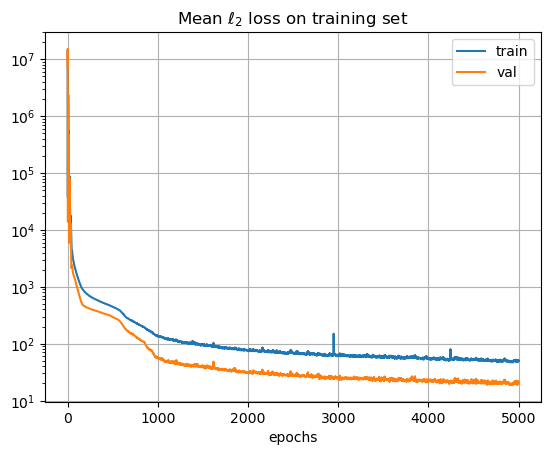

Test performance
MAE = 4.924087
max error = 30.188324
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 2: 0.01292109489440918
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 4: 0.010987520217895508
Num neurons initial =  1486
Num neurons final =  1458


cost,▁
mae,▁
max_error,▁
neurons,▁
train_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cost,5.06989
mae,4.92409
max_error,30.18832
neurons,1458
train_loss,49.55144


[I 2023-07-31 14:16:11,000] Trial 7 finished with value: 5.069887047576905 and parameters: {'h_layers': 2, 'h_units': 743, 'learning_rate': 0.012230617176362911, 'l2_reg': 0.015667649766687813, 'l2_second_deriv_reg': 0.005569296837429928, 'weigth_decay': 1.710132518475105e-05, 'eps_reg': 0.09336625097956391}. Best is trial 7 with value: 5.069887047576905.
/home/seman/env/relu2/lib/python3.11/site-packages/jax/_src/random.py:463: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


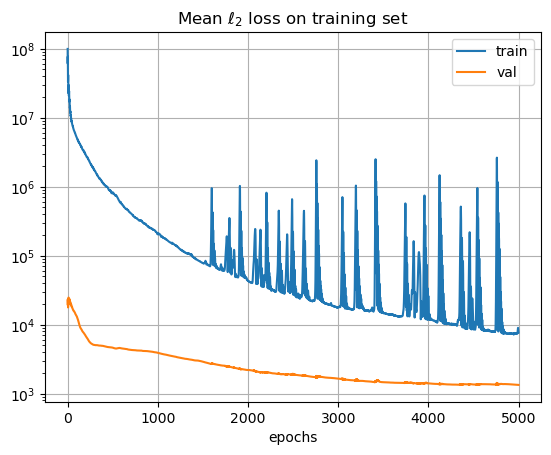

Test performance
MAE = 40.36148
max error = 179.3764
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 2: 0.007935762405395508
Num neurons initial =  444
Num neurons final =  444


cost,▁
mae,▁
max_error,▁
neurons,▁
train_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cost,40.40588
mae,40.36148
max_error,179.3764
neurons,444
train_loss,7664.53467


[I 2023-07-31 14:16:27,386] Trial 8 finished with value: 40.40588071289063 and parameters: {'h_layers': 1, 'h_units': 444, 'learning_rate': 0.0017305985140489077, 'l2_reg': 4.700412727170233e-05, 'l2_second_deriv_reg': 0.08242177829096593, 'weigth_decay': 8.55293152059637e-05, 'eps_reg': 1.9991229383895998e-05}. Best is trial 7 with value: 5.069887047576905.
/home/seman/env/relu2/lib/python3.11/site-packages/jax/_src/random.py:463: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


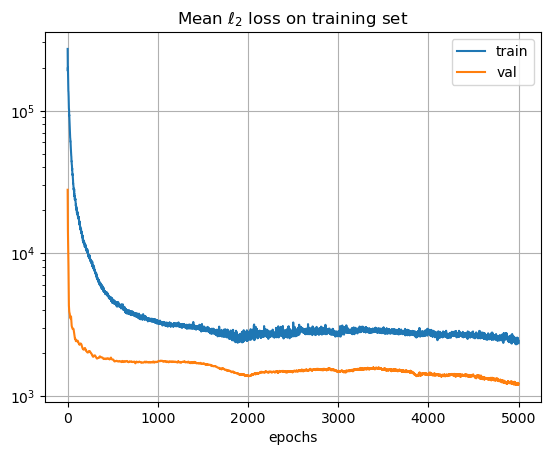

Test performance
MAE = 38.140312
max error = 180.9862
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 2: 0.011655807495117188
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 4: 0.010552406311035156
Num neurons initial =  632
Num neurons final =  627


cost,▁
mae,▁
max_error,▁
neurons,▁
train_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
cost,38.20301
mae,38.14031
max_error,180.98621
neurons,627
train_loss,2347.41016


[I 2023-07-31 14:16:48,578] Trial 9 finished with value: 38.20301219482422 and parameters: {'h_layers': 2, 'h_units': 316, 'learning_rate': 0.000345566107264291, 'l2_reg': 0.0037023051242322455, 'l2_second_deriv_reg': 0.0006672076469408077, 'weigth_decay': 1.579531960408226e-05, 'eps_reg': 0.00011109953769688464}. Best is trial 7 with value: 5.069887047576905.
/home/seman/env/relu2/lib/python3.11/site-packages/jax/_src/random.py:463: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


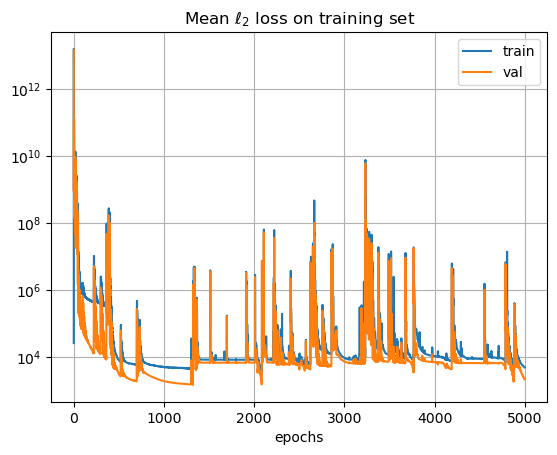

Test performance
MAE = 53.694626
max error = 199.31326
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 2: 0.01321268081665039
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 4: 0.019942045211791992
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 6: 0.032793283462524414
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 8: 0.045662641525268555
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 10: 0.021027565002441406
Num neurons initial =  4290
Num neurons final =  4239


cost,▁
mae,▁
max_error,▁
neurons,▁
train_loss,█▂▂▅▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▃▃█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▂▁▁▁▁▂▁▁▁▁▁▁
cost,54.11853
mae,53.69463
max_error,199.31326
neurons,4239
train_loss,4721.10645


[I 2023-07-31 14:19:30,560] Trial 10 finished with value: 54.11852585449219 and parameters: {'h_layers': 5, 'h_units': 858, 'learning_rate': 0.02537019751519252, 'l2_reg': 0.07781820205636782, 'l2_second_deriv_reg': 0.008977610533532219, 'weigth_decay': 1.2196379230149143e-05, 'eps_reg': 0.0893323760503863}. Best is trial 7 with value: 5.069887047576905.
/home/seman/env/relu2/lib/python3.11/site-packages/jax/_src/random.py:463: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


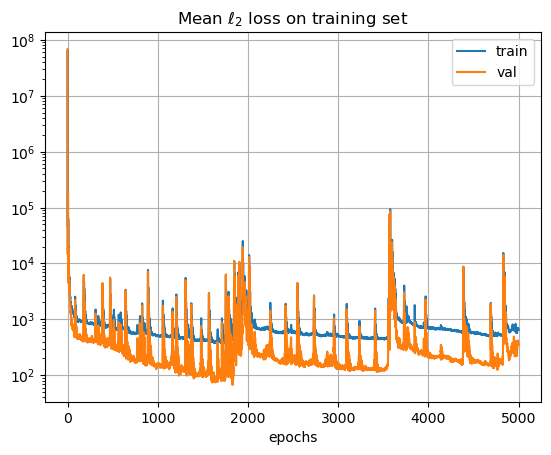

Test performance
MAE = 20.804972
max error = 111.06296
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 2: 0.011466741561889648
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 4: 0.0179595947265625
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 6: 0.02984023094177246
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 8: 0.01684260368347168
Num neurons initial =  3284
Num neurons final =  3279


cost,▁
mae,▁
max_error,▁
neurons,▁
train_loss,▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▂▁▁▁▁▁▁▁▁
val_loss,▂▁▁▂▂▃▁▃▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▄▁▁▁▁▁▁▁▁
cost,21.13287
mae,20.80497
max_error,111.06296
neurons,3279
train_loss,647.65552


[I 2023-07-31 14:21:37,402] Trial 11 finished with value: 21.13287169494629 and parameters: {'h_layers': 4, 'h_units': 821, 'learning_rate': 0.005064748419170401, 'l2_reg': 1.3266305676096453e-05, 'l2_second_deriv_reg': 0.005790929333942303, 'weigth_decay': 1.618196376269815e-05, 'eps_reg': 0.007705256642693868}. Best is trial 7 with value: 5.069887047576905.
/home/seman/env/relu2/lib/python3.11/site-packages/jax/_src/random.py:463: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


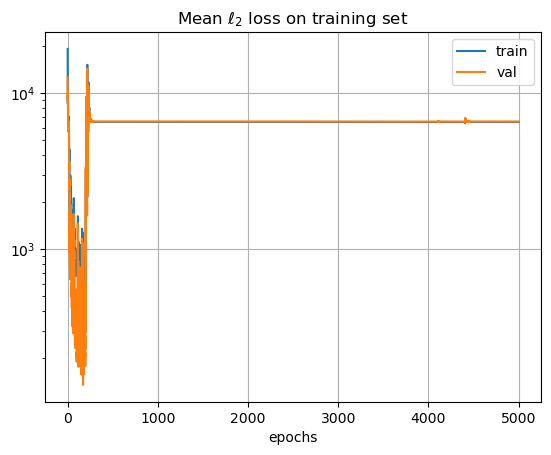

Test performance
MAE = 94.18774
max error = 322.8397
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 2: 0.008292436599731445
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 4: 0.01080465316772461
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 6: 0.014112472534179688
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 8: 0.017428874969482422
Num neurons initial =  60
Num neurons final =  20


cost,▁
mae,▁
max_error,▁
neurons,▁
train_loss,▁▁██████████████████████████████████████
val_loss,▁▁██████████████████████████████████████
cost,94.18974
mae,94.18774
max_error,322.83969
neurons,20
train_loss,6526.60156


[I 2023-07-31 14:21:52,165] Trial 12 finished with value: 94.18973651123046 and parameters: {'h_layers': 4, 'h_units': 15, 'learning_rate': 0.08734203870236812, 'l2_reg': 0.07619730245991184, 'l2_second_deriv_reg': 0.000247687195173093, 'weigth_decay': 5.516845463819774e-05, 'eps_reg': 0.0028379445146735132}. Best is trial 7 with value: 5.069887047576905.
/home/seman/env/relu2/lib/python3.11/site-packages/jax/_src/random.py:463: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


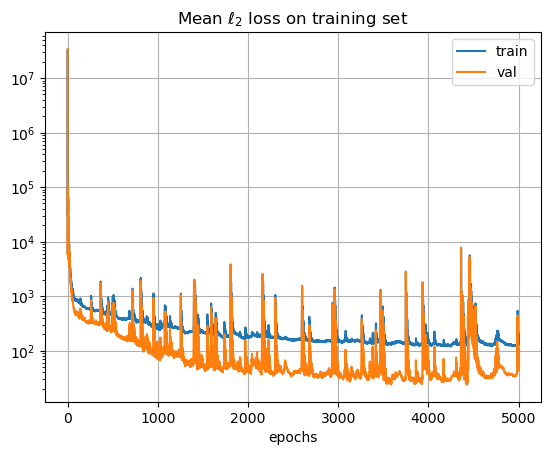

Test performance
MAE = 9.695559
max error = 35.873993
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 2: 0.01091909408569336
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 4: 0.014751434326171875
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 6: 0.023514747619628906
<class 'plnn.proxlp_solver.propagation.Propagation'> Time used for layer 8: 0.016498088836669922
Num neurons initial =  2964
Num neurons final =  2953


cost,▁
mae,▁
max_error,▁
neurons,▁
train_loss,█▅▄▄▅▃▃▃▂▂▂▃▂▂▁▂▁▇▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁
val_loss,█▆▄▅▄▂▂▂▂▂▂▅▁▁▁▁▁▂█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▃
cost,9.99086
mae,9.69556
max_error,35.87399
neurons,2953
train_loss,131.61343


[I 2023-07-31 14:23:41,129] Trial 13 finished with value: 9.990858547973632 and parameters: {'h_layers': 4, 'h_units': 741, 'learning_rate': 0.004769781539665229, 'l2_reg': 0.00041182911365859204, 'l2_second_deriv_reg': 0.007568393791914364, 'weigth_decay': 0.0002756853912626045, 'eps_reg': 0.01508157334147427}. Best is trial 7 with value: 5.069887047576905.
/home/seman/env/relu2/lib/python3.11/site-packages/jax/_src/random.py:463: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


[W 2023-07-31 14:24:02,412] Trial 14 failed with parameters: {'h_layers': 3, 'h_units': 677, 'learning_rate': 0.0011915423354553463, 'l2_reg': 0.021782849357472062, 'l2_second_deriv_reg': 0.004801341410358806, 'weigth_decay': 2.738740681914284e-05, 'eps_reg': 0.002105355622935389} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/seman/env/relu2/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_39032/1767881430.py", line 15, in objective
    net = net.fit(
          ^^^^^^^^
  File "/data/br/relu-or-pwl/src/net.py", line 217, in fit
    self._run_epoch(X_, y_, X_val, y_val, bandit, step, val_step,
  File "/data/br/relu-or-pwl/src/net.py", line 367, in _run_epoch
    loss_value, val_loss_value = super()._run_epoch(X_, y_, X_val, y_val,
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File 

KeyboardInterrupt: 

In [11]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)